## 3-1 프로젝트: ResNet Ablation Study
---
### 1) ResNet 기본 블록 구성하기
---
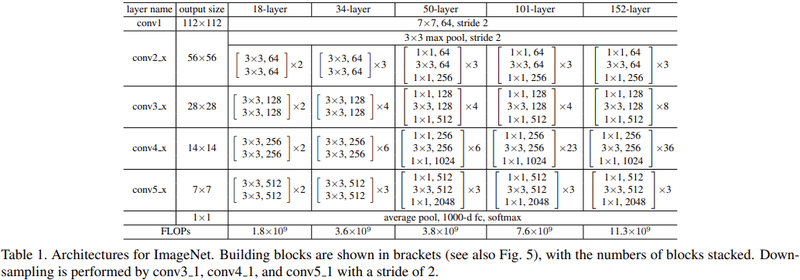  
ResNet-34와 ResNet-50은 모두 conv block이라고 불리는 블록 구조를 각각 3, 4, 6, 3개씩 반복해서 쌓은 형태  

ResNet-34와 ResNet-50의 블록 내부 구성  
- ResNet-34 : 3x3 kernel인 Convolution layer로만 구성
- ResNet-50 : 1x1 Convolution이 앞뒤로 붙어 더 많은 레이어를 한 블록 내 구성

### 기본 블럭 생성 함수

In [1]:
import tensorflow as tf
from tensorflow.keras import layers, Model
import numpy as np 

def resnet_block(input_layer, filters, strides=1, is_50=False, is_plain=False):
    first_kernel_size = 3
    first_padding = 'same'
    last_filters = filters    
    if is_50:
        first_kernel_size = 1
        first_padding = 'valid'
        last_filters = filters * 4
    
    x = layers.Conv2D(filters, kernel_size=first_kernel_size, strides=strides, padding=first_padding)(input_layer)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    
    x = layers.Conv2D(filters, kernel_size=3, strides=1, padding='same')(x)
    x = layers.BatchNormalization()(x)
    
    if is_50:
        x = layers.Activation('relu')(x)
        x = layers.Conv2D(last_filters, kernel_size=1, strides=1, padding='valid')(x)
        x = layers.BatchNormalization()(x)
    
    if is_plain==False:
        # 잔차 연결
        shortcut = input_layer
        if strides > 1 or is_50:
            shortcut = layers.Conv2D(last_filters, kernel_size=1, strides=strides, padding=first_padding)(shortcut)
            if strides > 1:
                shortcut = layers.BatchNormalization()(shortcut)    
        x = layers.Add()([x, shortcut])
        
    x = layers.Activation('relu')(x)
    return x

def build_resnet(input_shape, num_classes, is_50=False, is_plain=False):
    # input layer
    input_layer = layers.Input(shape=input_shape)
    
    x = input_layer
        
    # Conv1
    x = layers.Conv2D(64, 7, strides=2, padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
        
    # Conv2
    x = layers.MaxPool2D(pool_size=(3, 3), strides=2, padding='same')(x)
    for i in range(3):
        x = resnet_block(x, 64, 1, is_50, is_plain)
    
    # Conv3
    for i in range(4):
        s = 1
        if i==0:
            s = 2
        x = resnet_block(x, 128, s, is_50, is_plain)
    
    # Conv4
    for i in range(6):
        s = 1
        if i==0:
            s = 2
        x = resnet_block(x, 256, s, is_50, is_plain)
        
    # Conv5
    for i in range(3):
        s = 1
        if i==0:
            s = 2
        x = resnet_block(x, 512, s, is_50, is_plain)
    
    x = layers.GlobalAveragePooling2D()(x)
    outputs = layers.Dense(num_classes, activation="softmax")(x)
    
    return Model(
        inputs=input_layer, 
        outputs=outputs
    )

### 2) ResNet-34, ResNet-50 Complete Model
Functional API 를 구성하는 방식을 사용  
ResNet-34와 ResNet-50의 차이에 따라 달라지는 구성(configuration)을 build_resnet() 함수에 전달해서 ResNet의 여러 가지 버전 생성  

#### ResNet-34 

In [2]:
resnet_34 = build_resnet(input_shape=(32, 32, 3), num_classes=10, is_50=False)
resnet_34.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 16, 16, 64)   9472        input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 16, 16, 64)   256         conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 16, 16, 64)   0           batch_normalization[0][0]        
______________________________________________________________________________________________

#### ResNet-50

In [3]:
resnet_50 = build_resnet(input_shape=(32, 32,3), num_classes=10, is_50=True)
resnet_50.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
conv2d_36 (Conv2D)              (None, 16, 16, 64)   9472        input_2[0][0]                    
__________________________________________________________________________________________________
batch_normalization_36 (BatchNo (None, 16, 16, 64)   256         conv2d_36[0][0]                  
__________________________________________________________________________________________________
activation_33 (Activation)      (None, 16, 16, 64)   0           batch_normalization_36[0][0]     
____________________________________________________________________________________________

### 3) 일반 네트워크(plain network) 만들기
skip connection이 없는 PlainNet 모델 생성

#### ResNet-34과 skip connection이 없는 PlainNet-34 생성  
입력 이미지의 크기는 (224, 224, 3)

In [4]:
resnet_34 = build_resnet(input_shape=(224, 224, 3), num_classes=10, is_50=False)
resnet_34.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv2d_101 (Conv2D)             (None, 112, 112, 64) 9472        input_3[0][0]                    
__________________________________________________________________________________________________
batch_normalization_88 (BatchNo (None, 112, 112, 64) 256         conv2d_101[0][0]                 
__________________________________________________________________________________________________
activation_82 (Activation)      (None, 112, 112, 64) 0           batch_normalization_88[0][0]     
____________________________________________________________________________________________

In [5]:
plainnet_34 = build_resnet(input_shape=(224, 224, 3), num_classes=10, is_50=False, is_plain=True)
plainnet_34.summary()

Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
conv2d_137 (Conv2D)          (None, 112, 112, 64)      9472      
_________________________________________________________________
batch_normalization_124 (Bat (None, 112, 112, 64)      256       
_________________________________________________________________
activation_115 (Activation)  (None, 112, 112, 64)      0         
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 56, 56, 64)        0         
_________________________________________________________________
conv2d_138 (Conv2D)          (None, 56, 56, 64)        36928     
_________________________________________________________________
batch_normalization_125 (Bat (None, 56, 56, 64)        256 

#### ResNet-50과 skip connection이 없는 PlainNet-50 생성  
입력 이미지의 크기는 (224, 224, 3)

In [6]:
resnet_50 = build_resnet(input_shape=(224, 224, 3), num_classes=10, is_50=True)
resnet_50.summary()

Model: "model_4"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv2d_170 (Conv2D)             (None, 112, 112, 64) 9472        input_5[0][0]                    
__________________________________________________________________________________________________
batch_normalization_157 (BatchN (None, 112, 112, 64) 256         conv2d_170[0][0]                 
__________________________________________________________________________________________________
activation_148 (Activation)     (None, 112, 112, 64) 0           batch_normalization_157[0][0]    
____________________________________________________________________________________________

In [7]:
plainnet_50 = build_resnet(input_shape=(224, 224, 3), num_classes=10, is_50=True, is_plain=True)
plainnet_50.summary()

Model: "model_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
conv2d_235 (Conv2D)          (None, 112, 112, 64)      9472      
_________________________________________________________________
batch_normalization_209 (Bat (None, 112, 112, 64)      256       
_________________________________________________________________
activation_197 (Activation)  (None, 112, 112, 64)      0         
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 56, 56, 64)        0         
_________________________________________________________________
conv2d_236 (Conv2D)          (None, 56, 56, 64)        4160      
_________________________________________________________________
batch_normalization_210 (Bat (None, 56, 56, 64)        256 

### 4) ResNet-50 vs Plain-50 또는 ResNet-34 vs Plain-34
ResNet-50 vs Plain-50 또는 ResNet-34 vs Plain-34에 대해서 학습을 진행 및 결과 비교  

ResNet은 많은 레이어와 Pooling을 거치므로 CIFAR-10에서는 오버피팅(overfitting)으로 잘 동작하지 않을 수 있다.  
레이어가 많고 학습해야 할 변수(parameter)가 많은 데 비해, 데이터 수가 많지 않기 때문  

tensorflow-datasets에서 제공하는 horses_or_humans 데이터셋 사용  

학습을 통해 만들어진 history를 matplotlib로 시각화하여 두 모델의 검증 정확도(validation accuracy)와 검증 손실(validation loss)이 어떻게 다른지 시각화 비교  

#### 데이터 준비


In [10]:
from tensorflow.keras.datasets import cifar10

(x_train, y_train), (x_test, y_test)=cifar10.load_data()

print('Shape of x_train is {}'.format(x_train.shape))
print('Shape of x_test is {}'.format(x_test.shape))
print('Shape of y_train is {}'.format(y_train.shape))
print('Shape of y_test is {}'.format(y_test.shape))

from tensorflow.keras.utils import to_categorical

# Normalizing
x_train=x_train/255
x_test=x_test/255

#One hot encoding
y_train_cat=to_categorical(y_train,10)
y_test_cat=to_categorical(y_test,10)
import random

val_index = random.sample(range(50000),15000)
train_index = [x for x in range(50000) if x not in val_index]
x_val = x_train[val_index]
y_val = y_train[val_index]

x_train = x_train[train_index]
y_train = y_train[train_index]
print('Shape of x_train is {}'.format(x_train.shape))
print('Shape of x_val is {}'.format(x_val.shape))
print('Shape of x_test is {}'.format(x_test.shape))
print()
print('Shape of y_train is {}'.format(y_train.shape))
print('Shape of y_val is {}'.format(y_val.shape))
print('Shape of y_test is {}'.format(y_test.shape))

170508288/170498071 [==============================] - 3s 0us/step
Shape of x_train is (50000, 32, 32, 3)
Shape of x_test is (10000, 32, 32, 3)
Shape of y_train is (50000, 1)
Shape of y_test is (10000, 1)
Shape of x_train is (35000, 32, 32, 3)
Shape of x_val is (15000, 32, 32, 3)
Shape of x_test is (10000, 32, 32, 3)

Shape of y_train is (35000, 1)
Shape of y_val is (15000, 1)
Shape of y_test is (10000, 1)


---
### resnet 34 모델 vs plainnet 34 모델
#### resnet 34 모델 학습

In [18]:
es = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    min_delta = 0.0005,
    mode = 'auto',
    patience=10,
    verbose=1)
epochs = 30
batch_size = 128

resnet_34 = build_resnet(input_shape=(32, 32, 3), num_classes=10, is_50=False)
resnet_34.compile(loss='sparse_categorical_crossentropy',optimizer='adam',metrics=['accuracy'])
h_resnet_34 =resnet_34.fit(x_train,
                           y_train,
                           validation_data = (x_val, y_val),
                           batch_size = batch_size,
                           epochs = epochs,
                           callbacks = es)

Epoch 1/30
274/274 [==============================] - 18s 56ms/step - loss: 1.6080 - accuracy: 0.4331 - val_loss: 4.0417 - val_accuracy: 0.1087
Epoch 2/30
274/274 [==============================] - 14s 52ms/step - loss: 1.1824 - accuracy: 0.5802 - val_loss: 2.0129 - val_accuracy: 0.3642
Epoch 3/30
274/274 [==============================] - 14s 53ms/step - loss: 0.9725 - accuracy: 0.6558 - val_loss: 1.4260 - val_accuracy: 0.5273
Epoch 4/30
274/274 [==============================] - 15s 53ms/step - loss: 0.8527 - accuracy: 0.6991 - val_loss: 1.3476 - val_accuracy: 0.5634
Epoch 5/30
274/274 [==============================] - 15s 53ms/step - loss: 0.7414 - accuracy: 0.7403 - val_loss: 1.8127 - val_accuracy: 0.4725
Epoch 6/30
274/274 [==============================] - 14s 53ms/step - loss: 0.6870 - accuracy: 0.7577 - val_loss: 1.2042 - val_accuracy: 0.6289
Epoch 7/30
274/274 [==============================] - 14s 53ms/step - loss: 0.5672 - accuracy: 0.8012 - val_loss: 1.3102 - val_accuracy:

#### plainnet 34 모델 학습

In [19]:
plainnet_34 = build_resnet(input_shape=(32, 32, 3), num_classes=10, is_50=False, is_plain=True)
plainnet_34.compile(loss='sparse_categorical_crossentropy',optimizer='adam',metrics=['accuracy'])
h_plainnet_34 =plainnet_34.fit(x_train,
                           y_train,
                           validation_data = (x_val, y_val),
                           batch_size = batch_size,
                           epochs = epochs,
                           callbacks = es)

Epoch 1/30
274/274 [==============================] - 18s 57ms/step - loss: 1.9657 - accuracy: 0.2376 - val_loss: 3.6910 - val_accuracy: 0.1071
Epoch 2/30
274/274 [==============================] - 14s 51ms/step - loss: 1.7741 - accuracy: 0.3142 - val_loss: 2.9074 - val_accuracy: 0.2200
Epoch 3/30
274/274 [==============================] - 14s 52ms/step - loss: 1.7765 - accuracy: 0.3275 - val_loss: 4.1628 - val_accuracy: 0.2257
Epoch 4/30
274/274 [==============================] - 14s 51ms/step - loss: 1.8651 - accuracy: 0.2941 - val_loss: 2.4144 - val_accuracy: 0.1062
Epoch 5/30
274/274 [==============================] - 14s 51ms/step - loss: 1.8906 - accuracy: 0.2627 - val_loss: 2.0784 - val_accuracy: 0.2738
Epoch 6/30
274/274 [==============================] - 14s 51ms/step - loss: 1.7336 - accuracy: 0.3399 - val_loss: 2.2463 - val_accuracy: 0.2271
Epoch 7/30
274/274 [==============================] - 14s 51ms/step - loss: 1.6830 - accuracy: 0.3670 - val_loss: 2.5163 - val_accuracy:

#### 시각화 비교

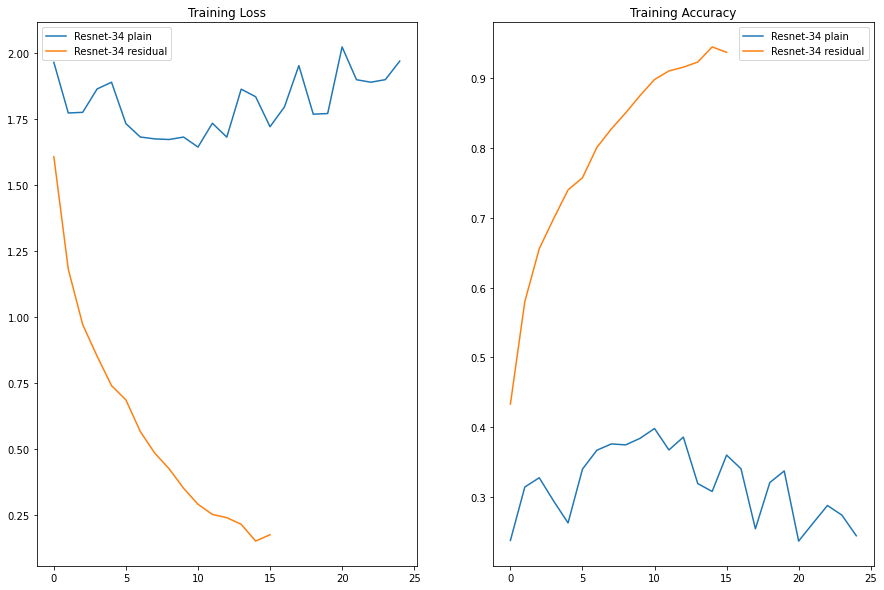

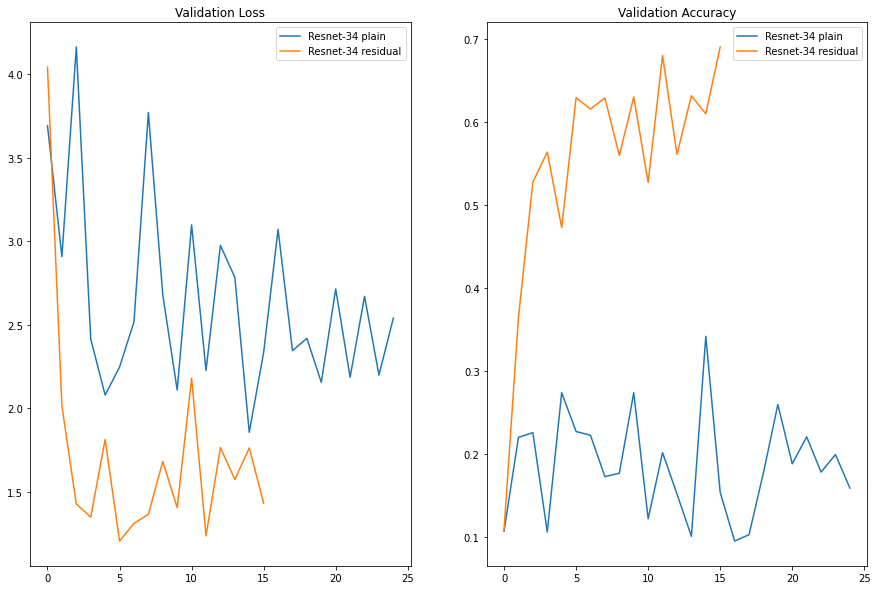

In [22]:
import matplotlib.pyplot as plt

def Show_log(history1, history2 , names):
    fig, ax = plt.subplots(1,2, figsize=(15,10))
    ax[0].plot(range(len(history1.history['loss'])), history1.history['loss'], label = names[0])
    ax[0].plot(range(len(history2.history['loss'])), history2.history['loss'], label = names[1])
    ax[0].set_title('Training Loss')
    ax[0].legend()

    ax[1].plot(range(len(history1.history['accuracy'])), history1.history['accuracy'], label = names[0])
    ax[1].plot(range(len(history2.history['accuracy'])), history2.history['accuracy'], label = names[1])
    ax[1].set_title('Training Accuracy')
    ax[1].legend()

    plt.show()

def Show_val_log(history1, history2 , names):
    fig, ax = plt.subplots(1,2, figsize=(15,10))
    ax[0].plot(range(len(history1.history['val_loss'])), history1.history['val_loss'], label = names[0])
    ax[0].plot(range(len(history2.history['val_loss'])), history2.history['val_loss'], label = names[1])
    ax[0].set_title('Validation Loss')
    ax[0].legend()

    ax[1].plot(range(len(history1.history['accuracy'])),history1.history['val_accuracy'], label = names[0])
    ax[1].plot(range(len(history2.history['accuracy'])),history2.history['val_accuracy'], label = names[1])
    ax[1].set_title('Validation Accuracy')
    ax[1].legend()

    plt.show()
# import matplotlib.pyplot as plt

# def Show_log(history1, history2 , names):
#     fig, ax = plt.subplots(1,2, figsize=(10,5))
#     ax[0].plot(history1.history['loss'],range(len(history1.history['loss'])), label = names[0])
#     ax[0].plot(history2.history['loss'],range(len(history2.history['loss'])), label = names[1])
#     ax[0].set_title('Training Loss')
#     ax[0].legend()

#     ax[1].plot(history1.history['accuracy'],range(len(history1.history['accuracy'])), label = names[0])
#     ax[1].plot(history2.history['accuracy'],range(len(history2.history['accuracy'])), label = names[1])
#     ax[1].set_title('Training Accuracy')
#     ax[1].legend()

#     plt.show()

# def Show_val_log(history1, history2 , names):
#     fig, ax = plt.subplots(1,2, figsize=(10,5))
#     ax[0].plot(history1.history['val_loss'],range(len(history1.history['loss'])), label = names[0])
#     ax[0].plot(history2.history['val_loss'],range(len(history2.history['loss'])), label = names[1])
#     ax[0].set_title('Validation Loss')
#     ax[0].legend()

#     ax[1].plot(history1.history['val_accuracy'],range(len(history1.history['accuracy'])), label = names[0])
#     ax[1].plot(history2.history['val_accuracy'],range(len(history2.history['accuracy'])), label = names[1])
#     ax[1].set_title('Validation Accuracy')
#     ax[1].legend()

#     plt.show()

Show_log(h_plainnet_34, h_resnet_34 , ['Resnet-34 plain', 'Resnet-34 residual'])
Show_val_log(h_plainnet_34, h_resnet_34 , ['Resnet-34 plain', 'Resnet-34 residual'])


---
### resnet 50 모델 vs plainnet 50 모델
#### resnet 50 모델 학습

In [23]:
es = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    min_delta = 0.0005,
    mode = 'auto',
    patience=10,
    verbose=1)
epochs = 30
batch_size = 128

resnet_50 = build_resnet(input_shape=(32, 32, 3), num_classes=10, is_50=True)
resnet_50.compile(loss='sparse_categorical_crossentropy',optimizer='adam',metrics=['accuracy'])
h_resnet_50 =resnet_50.fit(x_train,
                           y_train,
                           validation_data = (x_val, y_val),
                           batch_size = batch_size,
                           epochs = epochs,
                           callbacks = es)

Epoch 1/30
274/274 [==============================] - 33s 96ms/step - loss: 2.1910 - accuracy: 0.2031 - val_loss: 2.3772 - val_accuracy: 0.1420
Epoch 2/30
274/274 [==============================] - 24s 87ms/step - loss: 1.7447 - accuracy: 0.3183 - val_loss: 1.8991 - val_accuracy: 0.2849
Epoch 3/30
274/274 [==============================] - 24s 89ms/step - loss: 1.5584 - accuracy: 0.4109 - val_loss: 1.9475 - val_accuracy: 0.3637
Epoch 4/30
274/274 [==============================] - 24s 89ms/step - loss: 1.4323 - accuracy: 0.4692 - val_loss: 2.1795 - val_accuracy: 0.3109
Epoch 5/30
274/274 [==============================] - 24s 88ms/step - loss: 1.3259 - accuracy: 0.5116 - val_loss: 1.7083 - val_accuracy: 0.4133
Epoch 6/30
274/274 [==============================] - 24s 88ms/step - loss: 1.2643 - accuracy: 0.5406 - val_loss: 1.8034 - val_accuracy: 0.4373
Epoch 7/30
274/274 [==============================] - 24s 88ms/step - loss: 1.1800 - accuracy: 0.5745 - val_loss: 1.8159 - val_accuracy:

#### plainnet 50 모델 학습

In [24]:
plainnet_50 = build_resnet(input_shape=(32, 32, 3), num_classes=10, is_50=True, is_plain=True)
plainnet_50.compile(loss='sparse_categorical_crossentropy',optimizer='adam',metrics=['accuracy'])
h_plainnet_50 =plainnet_50.fit(x_train,
                           y_train,
                           validation_data = (x_val, y_val),
                           batch_size = batch_size,
                           epochs = epochs,
                           callbacks = es)

Epoch 1/30
274/274 [==============================] - 21s 64ms/step - loss: 2.2662 - accuracy: 0.1578 - val_loss: 2.3984 - val_accuracy: 0.1025
Epoch 2/30
274/274 [==============================] - 16s 60ms/step - loss: 2.0521 - accuracy: 0.2235 - val_loss: 2.2832 - val_accuracy: 0.1427
Epoch 3/30
274/274 [==============================] - 16s 60ms/step - loss: 1.9556 - accuracy: 0.2497 - val_loss: 2.8253 - val_accuracy: 0.1665
Epoch 4/30
274/274 [==============================] - 16s 59ms/step - loss: 1.9077 - accuracy: 0.2747 - val_loss: 3.6477 - val_accuracy: 0.2019
Epoch 5/30
274/274 [==============================] - 16s 59ms/step - loss: 1.8433 - accuracy: 0.2922 - val_loss: 2.2780 - val_accuracy: 0.2073
Epoch 6/30
274/274 [==============================] - 16s 59ms/step - loss: 1.7968 - accuracy: 0.3204 - val_loss: 40.0058 - val_accuracy: 0.0967
Epoch 7/30
274/274 [==============================] - 16s 59ms/step - loss: 1.9692 - accuracy: 0.2565 - val_loss: 2.1374 - val_accuracy

### resnet 34 모델 vs resnet 50 모델 시각화 비교

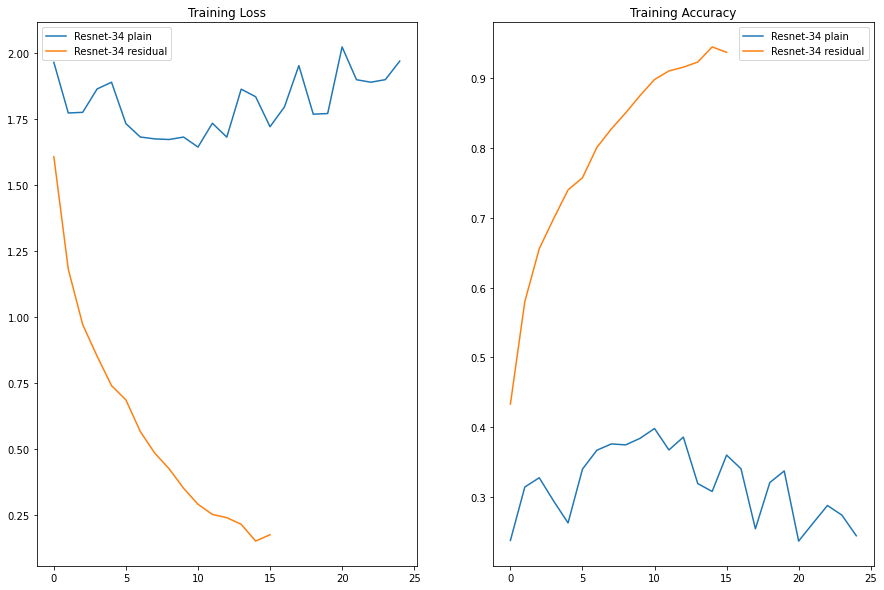

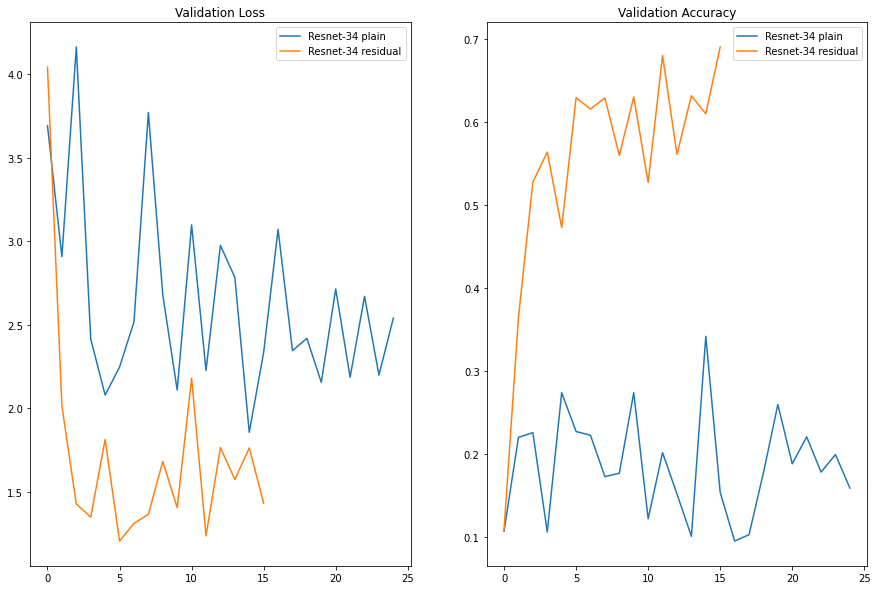

In [25]:
Show_log(h_plainnet_34, h_resnet_34 , ['Resnet-34 plain', 'Resnet-34 residual'])
Show_val_log(h_plainnet_34, h_resnet_34 , ['Resnet-34 plain', 'Resnet-34 residual'])

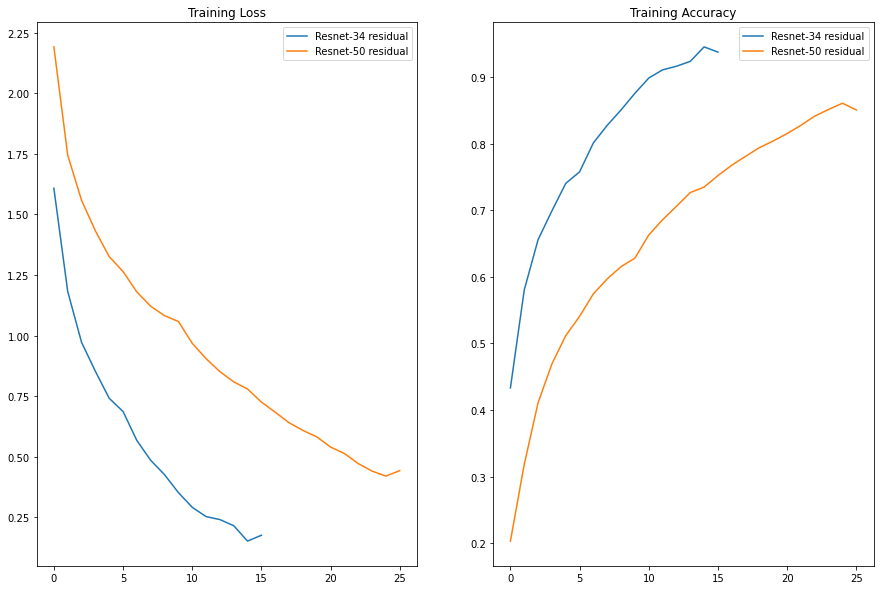

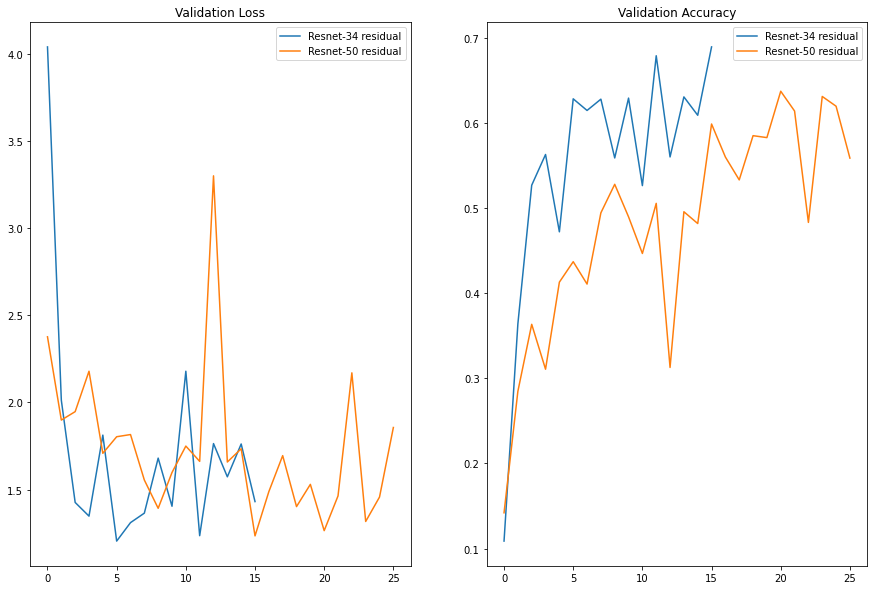

In [26]:
Show_log(h_resnet_34, h_resnet_50 , ['Resnet-34 residual', 'Resnet-50 residual'])
Show_val_log(h_resnet_34, h_resnet_50 , ['Resnet-34 residual', 'Resnet-50 residual'])

### 모델 테스트

In [40]:
loss, accuracy = plainnet_34.evaluate(x_test, y_test)
print('Resnet-34 plain')
print(f"Loss: {loss},\nAccuracy: {accuracy}")
print("------------------------------------------------")
loss, accuracy = resnet_34.evaluate(x_test, y_test)
print('Resnet-34 residual')
print(f"Loss: {loss},\nAccuracy: {accuracy}")
print("------------------------------------------------")
loss, accuracy = plainnet_50.evaluate(x_test, y_test)
print('Resnet-50 plain')
print(f"Loss: {loss},\nAccuracy: {accuracy}")
print("------------------------------------------------")
loss, accuracy = resnet_50.evaluate(x_test, y_test)
print('Resnet-50 residual')
print(f"Loss: {loss},\nAccuracy: {accuracy}")


313/313 [==============================] - 4s 12ms/step - loss: 2.5406 - accuracy: 0.1600
Resnet-34 plain
Loss: 2.540590763092041,
Accuracy: 0.1599999964237213
------------------------------------------------
313/313 [==============================] - 4s 12ms/step - loss: 1.4397 - accuracy: 0.6863
Resnet-34 residual
Loss: 1.439730167388916,
Accuracy: 0.6862999796867371
------------------------------------------------
313/313 [==============================] - 4s 13ms/step - loss: 2.6513 - accuracy: 0.1414
Resnet-50 plain
Loss: 2.651324510574341,
Accuracy: 0.14139999449253082
------------------------------------------------
313/313 [==============================] - 5s 17ms/step - loss: 1.8682 - accuracy: 0.5588
Resnet-50 residual
Loss: 1.868155837059021,
Accuracy: 0.5587999820709229


### 회고
|Model|Loss|Accuracy|
|:---|---:|---:|
|Resnet-34 plain|2.541|0.160|
|Resnet-34 residual|**1.440**|**0.686**|
|Resnet-50 plain|2.651|0.141|
|Resnet-50 residual|1.867|0.559|  

resnet-50이 (1,1)연산이 추가로 들어가기 때문에 레이어가 좀더 많아서  
overfitting의 문제로 resnet-34 residual의 성능이 제일 좋은 것으로 보임
